In this notebook, I'm using the IBM ART library(adversarial-robustness-toolbox) for finding the targeted adversarial examples. Check out the [source code and demo](https://github.com/IBM/adversarial-robustness-toolbox/tree/master/art) here.

In [1]:
import os

import numpy as np
import tensorflow as tf
import pydub
import matplotlib.pyplot as plt
from art.classifiers import KerasClassifier, TFClassifier
from art.attacks import FastGradientMethod, CarliniLInfMethod, CarliniL2Method
from art.attacks.evasion import DeepFool, ProjectedGradientDescent, UniversalPerturbation
import warnings
warnings.filterwarnings('ignore')
# import spec2audio as sta
from IPython.display import Audio

### Read training examples

In [2]:
TF_RECORD_DIR = '/scratch1/ilya/locDoc/data/alexa/v6cx2/train_80000'

In [3]:
#tfrecord_file = r'C:\Users\Ruijie Zheng\py3fst\v4e_5s_val_example.tfrecord'
# tfrecord_file = r'C:\Users\Ruijie Zheng\py3fst\train_80000\_clean_speech_00_0001.tfrecord'
tfrecord_file = os.path.join(TF_RECORD_DIR, '_clean_speech_00_0001.tfrecord')

spec_h = 256 # 80
# set some variables that are relavant to the network
network_example_length = 19840
hop_length = 160

examples = []
specs = []
spec_labs = []
limit = 100

for i, example in enumerate(tf.python_io.tf_record_iterator(tfrecord_file)):
    eg_np = tf.train.Example.FromString(example)
    audio_segment = pydub.AudioSegment(
        eg_np.features.feature["audio"].bytes_list.value[0], 
        frame_rate=16000,
        sample_width=2, 
        channels=1
    )
    y = audio_segment.get_array_of_samples()
    examples.append(y)

    spec = eg_np.features.feature["spectrogram"].float_list.value
    spec_labs.append(eg_np.features.feature["spectrogram_label"].int64_list.value)
    spec = np.array(spec).reshape(spec_h,-1)
    specs.append(spec)
    if i > limit:
        break

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [4]:
examples = np.array(examples)
specs = np.array(specs)
print(examples.shape)
print(specs.shape)

(101, 80000)
(101, 256, 500)


In [5]:
sound_i = 0
Audio(examples[sound_i], rate=16000)

### Slice the training example to feed into the network

In [6]:
batched_input = []
for i in range (specs.shape[0]):
    for j in range(specs.shape[-1]//31):
        start = 31 * j
        end = 31 * (j+1)
        batched_input.append(specs[i,:,start:end])
batched_input = np.array(batched_input)
print(batched_input.shape)

(1616, 256, 31)


In [18]:
print(specs.shape)
print(labels.shape)

(101, 256, 500)


NameError: name 'labels' is not defined

In [ ]:
batched_input = specs

## 2. Load wake word detection model

In [24]:
sess.close()

In [8]:
# model_dir = r'C:\Users\Ruijie Zheng\py3fst\MRFAR_exporter\1586995624'
model_dir = '/scratch0/ilya/locDoc/adv_audio_exports/len500_loss_normalv7/1588947580'
sess = tf.Session()
model = tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], model_dir)
predictor = tf.contrib.predictor.from_saved_model(model_dir)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /scratch0/ilya/locDoc/adv_audio_exports/len500_loss_normalv7/1588947580/variables/variables
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Restoring parameters from /scratch0/ilya/locDoc/adv_audio_exports/len500_loss_normalv7/1588947580/variables/variables


In [9]:
predictor

SavedModelPredictor with feed tensors {'spectrograms': <tf.Tensor 'Placeholder:0' shape=(?, 256, 500) dtype=float32>} and fetch_tensors {'output': <tf.Tensor 'Softmax:0' shape=(?, 470, 3) dtype=float32>}

In [11]:
# Load input and output tensor from model
signature = model.signature_def
signature_key = "serving_default"
input_key = "spectrograms"
output_key = "output"

x_tensor_name = signature["serving_default"].inputs[input_key].name
y_tensor_name = signature["serving_default"].outputs[output_key].name

input_x = sess.graph.get_tensor_by_name(x_tensor_name)
output_y = sess.graph.get_tensor_by_name(y_tensor_name)
output_y= tf.reshape(output_y,[-1,3])

In [12]:
input_x

<tf.Tensor 'Placeholder:0' shape=(?, 256, 500) dtype=float32>

In [13]:
output_y

<tf.Tensor 'Reshape:0' shape=(?, 3) dtype=float32>

In [16]:
# feed forward
masks = predictor({"spectrograms": batched_input })['output']

In [17]:
masks.shape

(101, 470, 3)

In [40]:
masks = predictor({"spectrograms": batched_input })['output']
masks = masks.reshape([-1, 3])
test_example = batched_input[np.newaxis, 5, :, :]
labels=masks[np.newaxis, 5, :]
print(labels)

NameError: name 'batched_input' is not defined

In [11]:
#Define Loss Function
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=tf.reshape(output_y, [-1]), labels=tf.cast(tf.reshape(labels, [-1]), dtype=tf.float32)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
# ART libarary wrapper around the tensorflow model
classifier = TFClassifier(
    input_ph = input_x,
    output   = output_y,
    labels_ph = labels,
    loss = loss_op,
    clip_values = (np.min(batched_input),np.max(batched_input)),
    sess = sess
)

## Load attack

Here, I load the adversarial perturbations that I have already trained. You can also adjust the parameters and try. (My experience: for universal perturbation with DeepFool attack (default settings), if you set delta to be less than 0.18, it will take too long to train.)

In [13]:
#Find the Universal Perturbation (Default Attacker is DeepFool Attack) 
#universal_perturb = UniversalPerturbation(classifier, delta=0.18, max_iter=500)
#target = np.zeros(masks.shape)
#target[:,2]  = np.ones(masks.shape[0]) 
#adversarial = universal_perturb.generate(batched_input,target)
with np.load('adversarial.npz') as data:
    print(data)
    uni_adversarial=data['arr_0']

In [14]:
adversarial_perturb=np.mean(uni_adversarial-batched_input, axis=0)
uniform_adversarial = adversarial_perturb+test_example
print("L2 Norm of Adversarial Perturbation {}".format(np.mean(np.abs(uniform_adversarial-test_example)**2)))

L2 Norm of Adversarial Perturbation 0.10923832682599502


In [15]:
print("Model output for clean example:")
print(predictor({"spectrograms": test_example })['output'])
print("Model output for adversarial example:")
print(predictor({"spectrograms": uniform_adversarial })['output']) 

Model output for clean example:
[[[0.96915305 0.00160742 0.0292396 ]]]
Model output for adversarial example:
[[[2.8253771e-32 2.8896373e-29 1.0000000e+00]]]


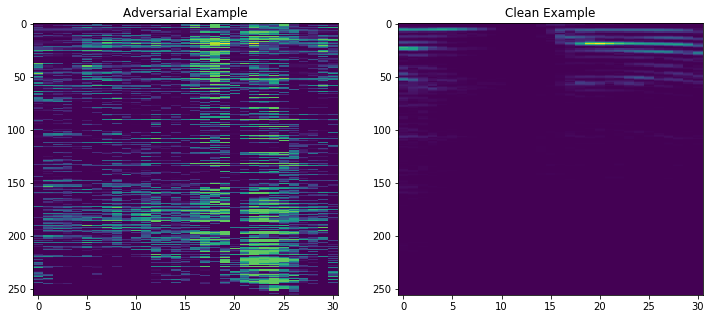

In [16]:
fig, (ax1, ax2) =plt.subplots(1, 2,figsize=(12,5))
_ = ax1.imshow(np.squeeze(uniform_adversarial,axis=0), aspect='auto')
_ = ax1.set_title("Adversarial Example")
_ = ax2.imshow( np.squeeze(test_example,axis=0), aspect='auto')
_ = ax2.set_title("Clean Example")

### Universal Perturbation with NewtonFool Attack

In [17]:
#nf_universal_perturb = UniversalPerturbation(classifier, attacker = 'newtonfool',delta=0.10, max_iter=500)
#target = np.zeros(masks.shape)
#target[:,2]  = np.ones(masks.shape[0]) 
#nf_uni_adversarial = nf_universal_perturb.generate(batched_input,target)
with np.load('nf_uniform_adversarial.npz') as data:
    print(data)
    nf_uni_adversarial=data['arr_0']

In [18]:
print("Average L2 Norm Perturbation {}".format(np.mean(np.abs(nf_uni_adversarial-batched_input)**2)))

Average L2 Norm Perturbation 0.0006275670031154762


In [19]:
nf_adversarial_perturb = np.mean(nf_uni_adversarial-batched_input, axis=0)
nf_adversarial_example = nf_adversarial_perturb+test_example

Here the thing I notice is that once I constrain the amount of perturbation of NewtonFool to a certain amouont, it will not give me the desired output (which I give as the target [0,0,1]). But still, they are indeed adversarial examples (the "power" of the adversarial example might be less)

In [20]:
print("Model output for clean example:")
print(predictor({"spectrograms": test_example })['output'])
print("Model output for adversarial example:")
print(predictor({"spectrograms": nf_adversarial_example })['output']) 

Model output for clean example:
[[[0.96915305 0.00160742 0.0292396 ]]]
Model output for adversarial example:
[[[4.6592558e-04 9.9953413e-01 8.9493357e-11]]]


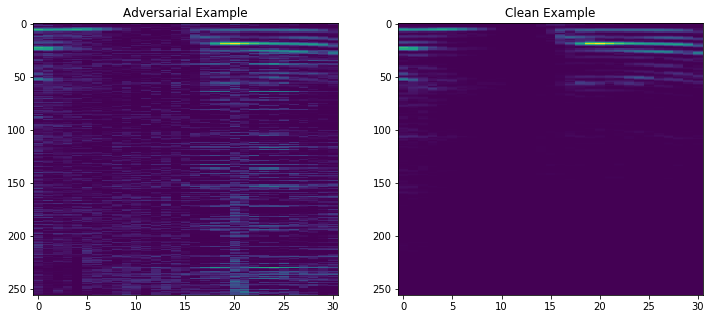

In [21]:
fig, (ax1, ax2) =plt.subplots(1, 2,figsize=(12,5))
_ = ax1.imshow(np.squeeze(nf_adversarial_example,axis=0), aspect='auto')
_ = ax1.set_title("Adversarial Example")
_ = ax2.imshow( np.squeeze(test_example,axis=0), aspect='auto')
_ = ax2.set_title("Clean Example")

### DeepFool Attack (attack on individual examples)

In [22]:
deepfool_attack = DeepFool(classifier, max_iter = 200)
target_y=np.array([0,0,1])
deepfool_adversarial = deepfool_attack.generate(x = test_example, y = target_y)
np.sum(np.abs(deepfool_adversarial-test_example)**2)

print("Model output for clean example:")
print(predictor({"spectrograms": test_example })['output'])
print("Model output for adversarial example:")
print(predictor({"spectrograms": deepfool_adversarial })['output']) 

Model output for clean example:
[[[0.96915305 0.00160742 0.0292396 ]]]
Model output for adversarial example:
[[[0.03817195 0.00258218 0.95924586]]]


In [23]:
np.mean(np.abs(deepfool_adversarial-test_example)**2)

3.2323892469682197e-07

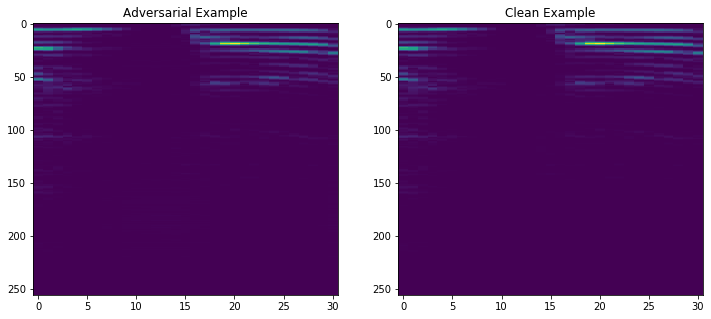

In [24]:
fig, (ax1, ax2) =plt.subplots(1, 2,figsize=(12,5))
_ = ax1.imshow(np.squeeze(deepfool_adversarial,axis=0), aspect='auto')
_ = ax1.set_title("Adversarial Example")
_ = ax2.imshow(np.squeeze(test_example, axis=0), aspect='auto')
_ = ax2.set_title("Clean Example")

### Gaussian Noise Perturbation

In [25]:
np.random.seed(10)
max_iter = 1000
i=0
history = []
while (i<max_iter):
    noise = np.random.normal(loc=0.0, scale=0.01, size=deepfool_adversarial.shape)
    adv = test_example+noise
    output = predictor({"spectrograms": adv })['output']
    history.append(noise)
    if (output.flatten()[0]<0.5):
        print("Norm of the perturbation",str(i),"{}".format(np.mean(noise**2)))
        print(output)
        print("\n")
    i+=1

Norm of the perturbation 216 9.925237616412798e-05
[[[0.4280379  0.00364906 0.56831306]]]


Norm of the perturbation 308 9.840444684067593e-05
[[[0.46132946 0.00411156 0.534559  ]]]


Norm of the perturbation 387 0.00010121972820668333
[[[0.30411032 0.00308244 0.6928072 ]]]


Norm of the perturbation 449 9.917475366217876e-05
[[[0.4414318  0.004086   0.55448216]]]


Norm of the perturbation 617 0.0001034420569953551
[[[0.46531698 0.00417842 0.5305046 ]]]


Norm of the perturbation 758 9.785994344007093e-05
[[[0.22130215 0.00349663 0.7752012 ]]]




In [26]:
# Perturbation History
noise_perturb = history[758]
gaussian_adv = test_example+noise_perturb
print("Perturbation L2 Norm: {}".format(np.mean(noise_perturb**2)))
print(predictor({"spectrograms": gaussian_adv })['output'])

Perturbation L2 Norm: 9.785994344007093e-05
[[[0.22130215 0.00349663 0.7752012 ]]]


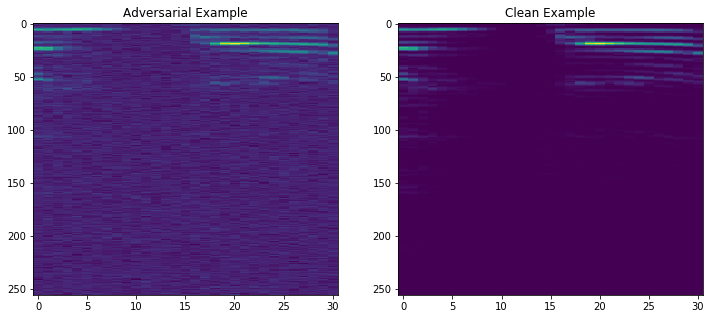

In [27]:
fig, (ax1, ax2) =plt.subplots(1, 2,figsize=(12,5))
_ = ax1.imshow(np.squeeze(gaussian_adv,axis=0), aspect='auto')
_ = ax1.set_title("Adversarial Example")
_ = ax2.imshow(np.squeeze(test_example, axis=0), aspect='auto')
_ = ax2.set_title("Clean Example")

### Recover audio from spectrogram 

In [28]:
n_fft, win_length, hop_length = 512, 400, 160

In [29]:
wav_df = sta.spec2wav(np.squeeze(deepfool_adversarial,axis=0), n_fft, win_length, hop_length, num_iters=500)
wav_clean = sta.spec2wav(np.squeeze(test_example,axis=0), n_fft, win_length, hop_length, num_iters=500)
wav_nf = sta.spec2wav(np.squeeze(nf_adversarial_example ,axis=0), n_fft, win_length, hop_length, num_iters=500)
wav_gaussian = sta.spec2wav(np.squeeze(gaussian_adv,axis=0), n_fft, win_length, hop_length, num_iters=500)

In [30]:
import IPython.display as ipd
sr = 16000
ipd.Audio(wav_clean,rate=sr)

In [31]:
ipd.Audio(wav_df,rate=sr)

In [32]:
#Uniform Perturbation
ipd.Audio(wav_nf,rate=sr)

In [33]:
ipd.Audio(wav_gaussian,rate=sr)

### Construct the adversarial examples of full-length

In [34]:
# Clean Example
example = specs[0,:,:]
wav = sta.spec2wav(example, n_fft, win_length, hop_length, num_iters=1000)
ipd.Audio(wav,rate=sr)

In [35]:
adv = np.zeros((256, 500))
for i in range(500//31):
    adv[:,i*31:(i+1)*31] = example[:,i*31:(i+1)*31]+nf_adversarial_perturb
wav = sta.spec2wav(adv, n_fft, win_length, hop_length, num_iters=1000)
ipd.Audio(wav,rate=sr)

In [36]:
# Slice the long audio into size-31 chunks and pass them into network
def compute_model_output(input_spec, size):
    output_1 = []
    output_2 = []
    output_3 = []
    for i in range(size//31):
        piece = input_spec[:,i*31:(i+1)*31]
        piece = np.expand_dims(piece, axis=0)
        model_output = predictor({"spectrograms": piece})['output']
        output_1.append(model_output[0,0,0])
        output_2.append(model_output[0,0,1])
        output_3.append(model_output[0,0,2])
    return output_1, output_2, output_3

In [37]:
output_1_clean, output_2_clean, output_3_clean = compute_model_output(example, 500)
output_1_adv, output_2_adv, output_3_adv = compute_model_output(adv, 500)

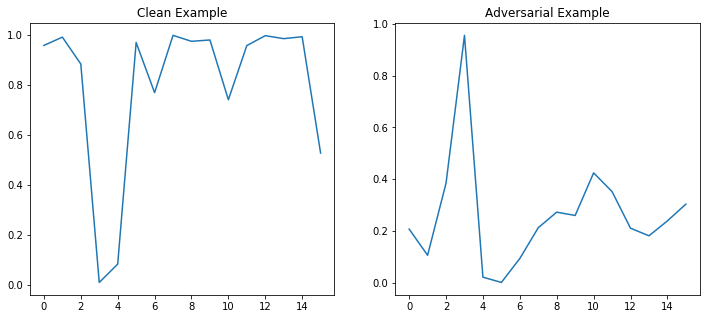

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.plot(output_1_clean)
ax1.set_title("Clean Example")

ax2.plot(output_1_adv)
ax2.set_title("Adversarial Example")

plt.show()

### Adversarial examples on individual examples

In [39]:
# Slice the long audio into size-31 chunks and pass them into network
def compute_deepfool_adv(input_spec, size):
    adv = np.zeros(input_spec.shape)
    for i in range(size//31):
        piece = input_spec[:,i*31:(i+1)*31]
        piece = np.expand_dims(piece, axis=0)
        target_y=np.array([0,0,1])
        adv[:,i*31:(i+1)*31] = deepfool_attack.generate(x = piece, y = target_y)   
    return adv

In [40]:
df_adversarial = compute_deepfool_adv(example, 500)

In [41]:
output_1_clean, output_2_clean, output_3_clean = compute_model_output(example, 500)
output_1_adv, output_2_adv, output_3_adv = compute_model_output(df_adversarial, 500)

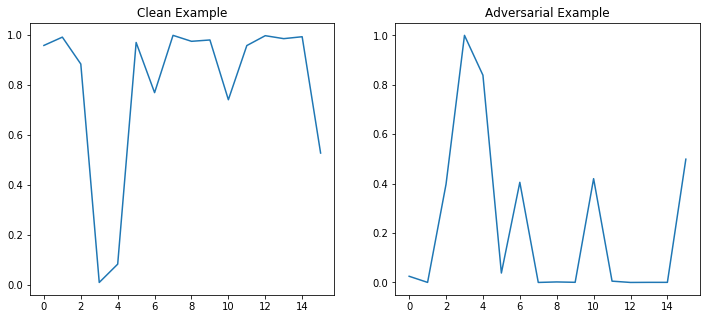

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.plot(output_1_clean)
ax1.set_title("Clean Example")

ax2.plot(output_1_adv)
ax2.set_title("Adversarial Example")

plt.show()

In [43]:
wav = sta.spec2wav(df_adversarial, n_fft, win_length, hop_length, num_iters=1000)
ipd.Audio(wav,rate=sr)